# Introduction

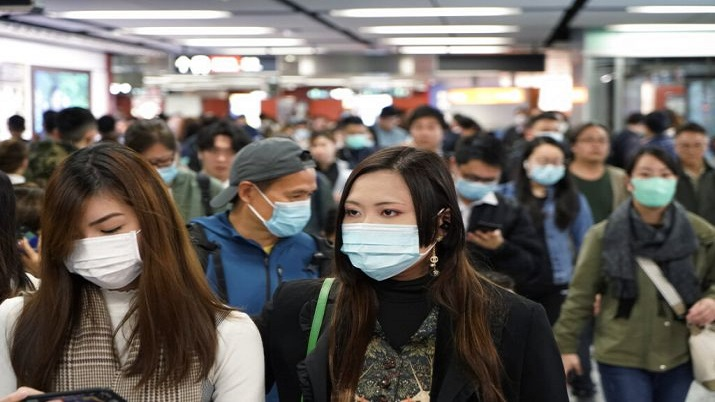

Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus.

Most people infected with the COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment.  Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.

The best way to prevent and slow down transmission is be well informed about the COVID-19 virus, the disease it causes and how it spreads. Protect yourself and others from infection by washing your hands or using an alcohol based rub frequently and not touching your face. 

The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes, so it’s important that you also practice respiratory etiquette (for example, by coughing into a flexed elbow).

At this time, there are no specific vaccines or treatments for COVID-19. However, there are many ongoing clinical trials evaluating potential treatments. WHO will continue to provide updated information as soon as clinical findings become available.

Stay informed:

Protect yourself: advice for the public
Myth busters
Questions and answers
Situation reports
All information on the COVID-19 outbreak

# Importing Necessary Packages

In [ ]:
! pip install calmap

In [ ]:
# essential libraries
import random
from datetime import timedelta  

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import calmap
import folium

# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML

# plot wtih holoviews + datashader - bokeh with map background
import holoviews as hv
import geoviews as gv
import datashader as ds
from colorcet import fire, rainbow, bgy, bjy, bkr, kb, kr
from datashader.colors import colormap_select, Greys9
from holoviews.streams import RangeXY
from holoviews.operation.datashader import datashade, dynspread, rasterize
from bokeh.io import push_notebook, show, output_notebook
output_notebook()
hv.extension('bokeh')
from folium import Marker,GeoJson,Choropleth, Circle
from folium.plugins import HeatMap
from folium.plugins import HeatMap, MarkerCluster
%opts Overlay [width=800 height=600 toolbar='above' xaxis=None yaxis=None]
%opts QuadMesh [tools=['hover'] colorbar=True] (alpha=0 hover_alpha=0.2)

T = 0.05
PX = 1


# Reading Data

In [ ]:
details= pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv', parse_dates=['Date'])
details.sample(6)

# Basic EDA

In [ ]:
details.describe()

In [ ]:
details.info()

In [ ]:
details.isna().sum()

In [ ]:
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']
details['total_cases']=details['Confirmed'] + details['Deaths'] + details['Recovered']
# Active Case = confirmed - deaths - recovered
details['Active'] = details['Confirmed'] - details['Deaths'] - details['Recovered']
# replacing Mainland china with just China
details['Country/Region'] = details['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
details[['Province/State']] = details[['Province/State']].fillna('')
details[cases] = details[cases].fillna(0)

# fixing datatypes
details['Recovered'] = details['Recovered'].astype(int)

details.sample(6)



In [ ]:
temp = details.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp = temp[temp['Date']==max(temp['Date'])].reset_index(drop=True)
temp['Global Moratality'] = temp['Deaths']/temp['Confirmed']
temp['Deaths per 100 Confirmed Cases'] = temp['Global Moratality']*100
temp.style.background_gradient(cmap='Pastel1')

# Country Wise data

In [ ]:
full_latest = details[details['Date'] == max(details['Date'])].reset_index()
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp_f = full_latest_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f[['Country/Region', 'Confirmed', 'Active', 'Deaths', 'Recovered']]
temp_f = temp_f.reset_index(drop=True)

temp_f.style.background_gradient(cmap="Blues", subset=['Confirmed', 'Active'])\
            .background_gradient(cmap="Greens", subset=['Recovered'])\
            .background_gradient(cmap="Reds", subset=['Deaths'])


In [ ]:
temp_flg = temp_f[temp_f['Deaths']>0][['Country/Region', 'Deaths']]
temp_flg['Deaths / 100 Cases'] = round((temp_f['Deaths']/temp_f['Confirmed'])*100, 2)
temp_flg.sort_values('Deaths', ascending=False).reset_index(drop=True).style.background_gradient(cmap='Reds')

# Geospatial Analysis

Across World

In [ ]:
# Confirmed
fig = px.choropleth(full_latest_grouped, locations="Country/Region", 
                    locationmode='country names', color=np.log(full_latest_grouped["Confirmed"]), 
                    hover_name="Country/Region", hover_data=['Confirmed'],
                    color_continuous_scale="peach", 
                    title='Countries with Confirmed Cases')
fig.update(layout_coloraxis_showscale=False)
fig.show()

By seeing the above map we can conclude that almost all the countries are suffering with this issue except Green Land and very some states in some countries

In [ ]:
# Deaths
temp = full_latest_grouped[full_latest_grouped['Deaths']>0]
fig = px.choropleth(temp, 
                    locations="Country/Region", locationmode='country names',
                    color=np.log(temp["Deaths"]), hover_name="Country/Region", 
                    color_continuous_scale="Peach", hover_data=['Deaths'],
                    title='Countries with Deaths Reported')
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [ ]:
formated_gdf = details.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['Confirmed'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Country/Region", locationmode='country names', 
                     color="Confirmed", size='size', hover_name="Country/Region", 
                     range_color= [0, max(formated_gdf['Confirmed'])+2], animation_frame="Date", 
                     title='Spread over time')
fig.update(layout_coloraxis_showscale=False)
fig.show()

The spread is very fast. It started in China and spread to the complete world

In [ ]:
formated_gdf = details.groupby(['Date', 'Country/Region'])['Recovered', 'Deaths'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['Recovered'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Country/Region", locationmode='country names', 
                     color="Recovered", size='size', hover_name="Country/Region", 
                     range_color= [0, max(formated_gdf['Recovered'])+2], animation_frame="Date", 
                     title='Recovery over time')
fig.update(layout_coloraxis_showscale=False)
fig.show()

From above interactive map we can say that recovery is very slow as compared to the spread.

**The only thing we can do is prevention. We have to follow some precautions: **
1. HANDS Wash them often
2. ELBOW Cough into it
3. FACE Don't touch it
4. SPACE Keep safe distance
5. HOME Stay if you can

Lets be a responsible citigen and follow these. 

In [ ]:
full_latest_grouped = full_latest.groupby('Country/Region')[ 'Confirmed', 'Deaths', 'Recovered','Active','Lat','Long'].sum().reset_index()

In [ ]:
full_latest_grouped.head()

In [ ]:
# Create a map
m = folium.Map(location=[54, 15], tiles='openstreetmap', zoom_start=2)

# Add points to the map
for idx, row in full_latest_grouped.iterrows():
    Marker([row['Lat'], row['Long']], popup=row['Confirmed']).add_to(m)

# Display the map
m

These are places which cases are Confirmed recently through the world in the past day alone

In [ ]:
# Create a map
m = folium.Map(location=[54, 15], tiles='openstreetmap', zoom_start=2)

# Add points to the map
for idx, row in full_latest_grouped.iterrows():
    Marker([row['Lat'], row['Long']], popup=row['Recovered']).add_to(m)

# Display the map
m

People from these places are recovered from corona virus in the past day alone

In [ ]:
# Create a map
m = folium.Map(location=[54, 15], tiles='openstreetmap', zoom_start=2)

# Add points to the map
for idx, row in full_latest_grouped.iterrows():
    Marker([row['Lat'], row['Long']], popup=row['Deaths']).add_to(m)

# Display the map
m

Deaths are from these marked placesin the past day alone

In [ ]:
# Create map with release incidents and monitoring stations
m = folium.Map(location=[54,15], zoom_start=2)
HeatMap(data=full_latest_grouped[['Lat', 'Long']], radius=15).add_to(m)

# Show the map
m

In these places the effect is more. The people from italy, Us, Spain,Chain, France, Germany must take more care. This is based only on the past day alone

If the same situation continues We will loose the hands, We have to definitely follow certain Precautions

In [ ]:
import math
m = folium.Map(location=[54,15], tiles='cartodbpositron', zoom_start=2)

# Add points to the map
mc = MarkerCluster()
for idx, row in full_latest_grouped.iterrows():
    if not math.isnan(row['Long']) and not math.isnan(row['Lat']):
        mc.add_child(Marker([row['Lat'], row['Long']]))
m.add_child(mc)

# Display the map
m

By seeing this map, we get the total count of cases through the world registered in the past day alone

In [ ]:
# Create map with overall cases registered
m = folium.Map(location=[54,15], zoom_start=2)
HeatMap(data=details[['Lat', 'Long']], radius=15).add_to(m)

# Show the map
m

In these regions the effect of corona virus is more till date. Countries like italy, China,Spain, France, US are suffering a lot.

In [ ]:
import math
m = folium.Map(location=[54,15], tiles='cartodbpositron', zoom_start=2)

# Add points to the map
mc = MarkerCluster()
for idx, row in details.iterrows():
    if not math.isnan(row['Long']) and not math.isnan(row['Lat']):
        mc.add_child(Marker([row['Lat'], row['Long']]))
m.add_child(mc)

# Display the map
m

These are the Total number cases registered till date in respective regions through out the world

If we do not Stay at home or doesnt take any precautions, it will leave a greater impact on our lives effecting various factors like stock markets, revenue, jobs, taxes, High rates ....etc

# STAY AT HOME AND DO KAGGLE

Lets all see this cases dropdown by sitting in home and by making this analysis

This notebook will be **Updated for every 24hrs** and you can see the latest visualization each day. You will see this notebook updated until corona virus cases are completely vanished

**Please Upvote If you like this Notebook and keep me motivated**